In [29]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statistics import mean
from datetime import date
import file

In [30]:
# Define the ticker symbol
tickerSymbol = 'MAGS'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
history = tickerData.history(interval='1wk', start='2021-1-1', end=date.today())

In [31]:

gap = 0 # %

option_prices = {
    2: [43/0.62, 56/1.05],
    4: [56/1.85],
    5: [45/1.62, 50/1.9],
    6: [43/1.80],
    7: [56/1.97],
    8: [46/1.55],
    9: [45/2.05, 51/1.8, 56/2.82],
    11: [59/2.65],
    13: [56/3.40],
    15: [43/2.27],
    17: [46/2.67],
    18: [45/3.35, 51/2.97],
    24: [56/4.4],
    26: [56/5.1],
    28: [43/3.45],
    30: [46/3.55],
    31: [45/4.05, 51/4.2],
}

print('option leverages:')
for w in sorted(option_prices.keys()):
    print(f'\t{w:2}w', *[f'{x:4.1f}' for x in option_prices[w]])

option_leverage = {w:mean(option_prices[w]) for w in option_prices}

# normalize values so longer expirations have lower leverage
option_leverage = {k: v for k, v in zip(sorted(option_leverage.keys()), sorted(option_leverage.values(), reverse=True))}

print('mean option leverage, break even:')
for w in sorted(option_leverage.keys()):
    print(f'\t{w:2}w {option_leverage[w]:4.1f} {gap + 100/option_leverage[w]:4.1f}%')
print(f'option gap: {gap:.2f}%')

file.save_option_leverage(tickerSymbol, option_leverage)

option leverages:
	 2w 69.4 53.3
	 4w 30.3
	 5w 27.8 26.3
	 6w 23.9
	 7w 28.4
	 8w 29.7
	 9w 22.0 28.3 19.9
	11w 22.3
	13w 16.5
	15w 18.9
	17w 17.2
	18w 13.4 17.2
	24w 12.7
	26w 11.0
	28w 12.5
	30w 13.0
	31w 11.1 12.1
mean option leverage, break even:
	 2w 61.3  1.6%
	 4w 30.3  3.3%
	 5w 29.7  3.4%
	 6w 28.4  3.5%
	 7w 27.0  3.7%
	 8w 23.9  4.2%
	 9w 23.4  4.3%
	11w 22.3  4.5%
	13w 18.9  5.3%
	15w 17.2  5.8%
	17w 16.5  6.1%
	18w 15.3  6.5%
	24w 13.0  7.7%
	26w 12.7  7.9%
	28w 12.5  8.0%
	30w 11.6  8.6%
	31w 11.0  9.1%
option gap: 0.00%


In [32]:
max_weeks = 52
stock_change = [None]
option_performance = []
for weeks in range(1, max_weeks+1):
    stock_changes = history['Close'].pct_change(periods=weeks) * 100
    stock_change.append(stock_changes.median()*52/weeks)
    window_max = history['High'].rolling(window=pd.api.indexers.FixedForwardWindowIndexer(window_size=weeks)).max()

    if weeks in option_leverage:
        lvr = option_leverage[weeks]
        option_profits = ((stock_changes[weeks:] - gap) * lvr - 100).clip(lower=-100)
        mean_profit = option_profits.mean() * 52 / weeks # annualized
        median_profit = option_profits.median()
        positive_percent = (option_profits > 0).mean() * 100
        wmax = (((window_max / history['Open'] - 1) * 100 - gap) * lvr - 100).clip(lower=-100).median() - 100
        option_performance.append([weeks, mean_profit, positive_percent, wmax, median_profit])
        history[f'Option {weeks}w'] = option_profits # * 52 / weeks # annualized

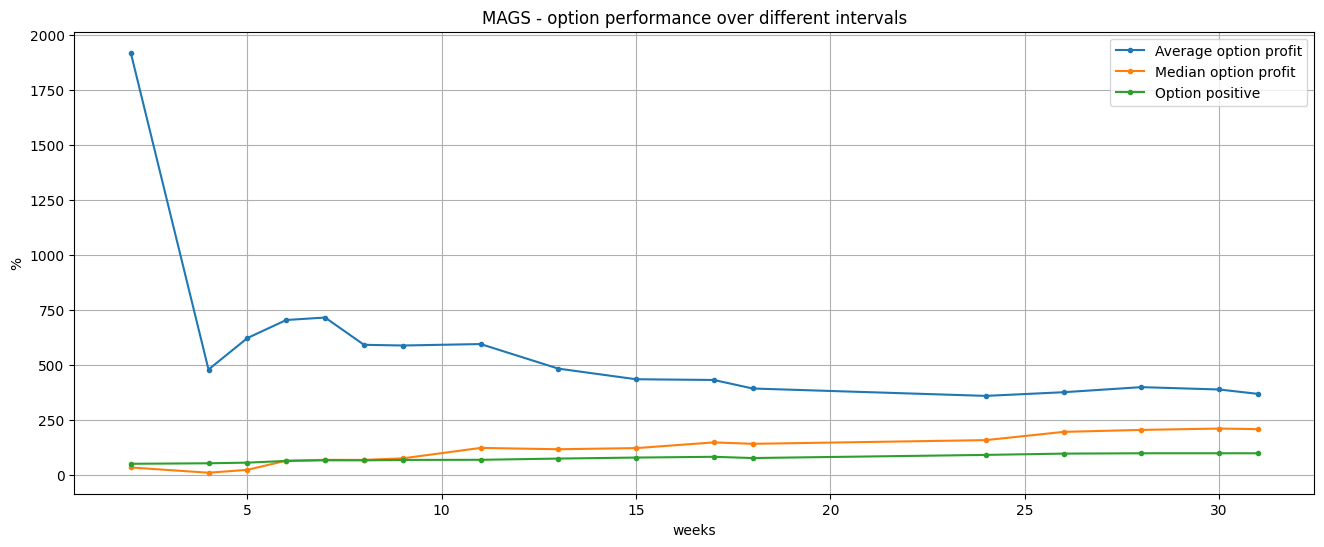

In [33]:
plt.figure(figsize=(16,6))
option_weeks = [p[0] for p in option_performance]
option_mean_profit = [p[1] for p in option_performance]
option_median_profit = [p[4] for p in option_performance]
option_positive = [p[2] for p in option_performance]
option_score = [x * y / 100 for x, y in zip(option_mean_profit, option_positive)]
plt.plot(option_weeks, option_mean_profit, label='Average option profit', marker='.')
plt.plot(option_weeks, option_median_profit, label='Median option profit', marker='.')
plt.plot(option_weeks, option_positive, label='Option positive', marker='.')
# plt.plot(option_weeks, option_score, label='Option score', marker='.')
plt.legend()
plt.title(f'{tickerSymbol} - option performance over different intervals')
plt.xlabel('weeks')
plt.ylabel('%')
plt.grid()
plt.show()

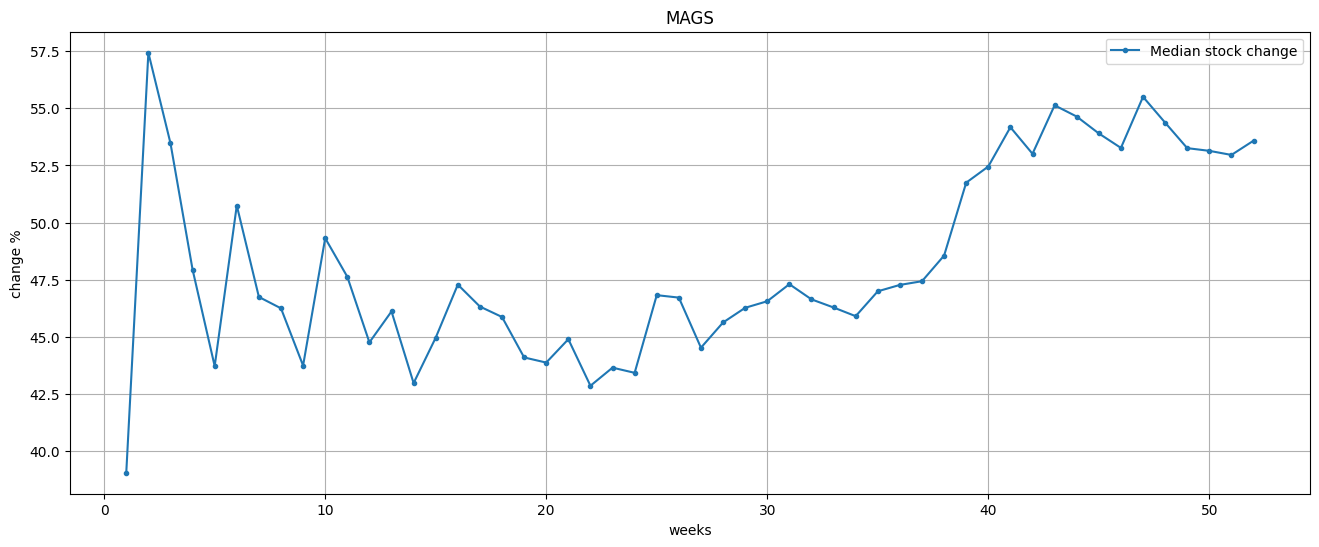

In [34]:
plt.figure(figsize=(16,6))
plt.plot(stock_change, label='Median stock change', marker='.')
plt.legend(loc='best')
plt.title(tickerSymbol)
plt.xlabel('weeks')
plt.ylabel('change %')
plt.grid()
plt.show()


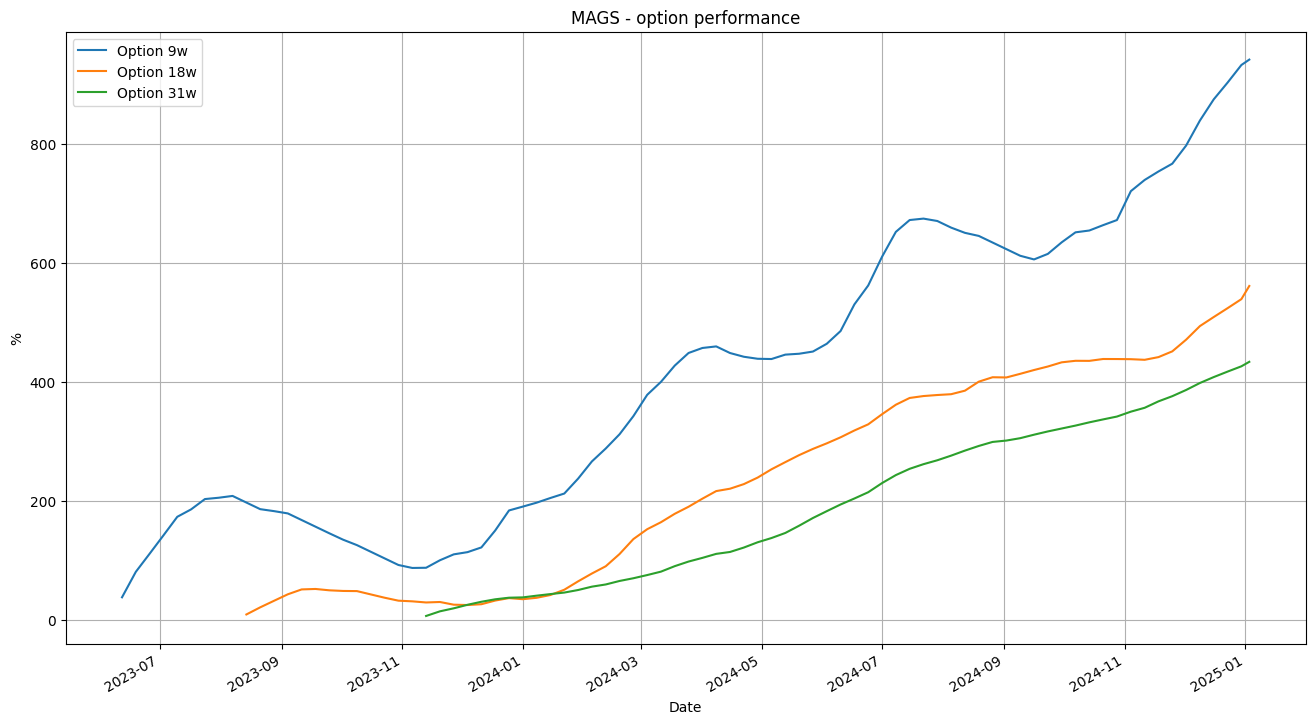

In [39]:
plt.figure(figsize=(16,9))

for w in [9,18,31]:
    (history[f'Option {w}w'].cumsum()/w).plot()

plt.legend()
plt.title(f'{tickerSymbol} - option performance')
plt.ylabel('%')
plt.grid()
plt.show()
